Классифицировать токены по времени оказали ли влияния события на стоимость. Построить распределение чего нибудь отражающее степень влияния события на стоимость

Попытаться предсказать стоимость в окрестности событий. Предсказать поведение стоимости при продаже заминченных токенов или нфт

In [13]:
import numpy as np
import scipy as sp
# import pytorch
import pandas as pd
import statsmodels.api as sm

import plotly.graph_objects as go # рисовать candlestick charts

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
%config InlineBackend.figure_format = 'svg'

from patsy import dmatrices

from requests import get # дергать апи coinapi.io


In [3]:
import scipy.stats as stats

Пайплайн: csv -> DataFrame -> кормим модели, получаем метрику качества, делаем выводы

# Данные с https://www.kaggle.com/competitions/g-research-crypto-forecasting

 The mapping from Asset_ID to crypto asset is contained in asset_details.csv.

In [4]:
crypto_df = pd.read_csv('train.csv')

In [4]:
df['Asset_ID'].unique()

array([ 2,  0,  1,  5,  7,  6,  9, 11, 13, 12,  3,  8, 10,  4])

In [5]:
btc = crypto_df[crypto_df["Asset_ID"]==1].set_index("timestamp") # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

In [6]:
# plotly krivoe govno, no nichego pohozhego net po funkcionalu :(
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])])
fig.show()

In [6]:
eth = crypto_df[crypto_df["Asset_ID"]==6].set_index("timestamp")

In [7]:
beg_btc = btc.index[0].astype('datetime64[s]')
end_btc = btc.index[-1].astype('datetime64[s]')
beg_eth = eth.index[0].astype('datetime64[s]')
end_eth = eth.index[-1].astype('datetime64[s]')

print('BTC data goes from ', beg_btc, 'to ', end_btc)
print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00
Ethereum data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


In [8]:
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')  # filling the blanks 

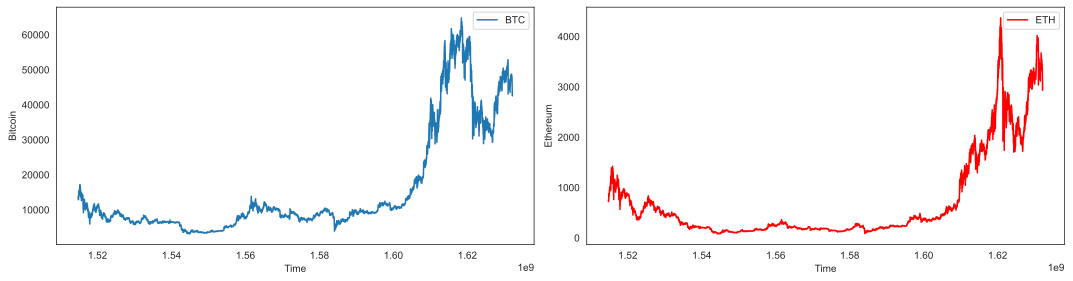

In [9]:
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

# fill missing values for BTC
btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

ax = f.add_subplot(121)
plt.plot(btc['Close'], label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='red', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

In [17]:
import time
from datetime import datetime

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create intervals
btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

NameError: name 'btc' is not defined

In [19]:
# this is for normalizing purposes

# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

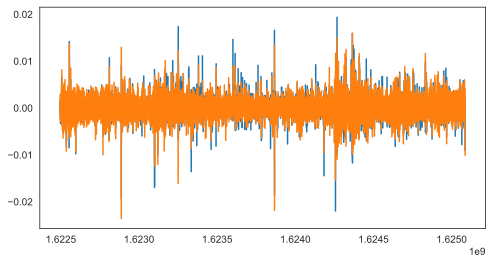

In [12]:
lret_btc = log_return(btc_mini_2021.Close)[1:]
lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(8,4))
plt.plot(lret_btc);
plt.plot(lret_eth);
plt.show()

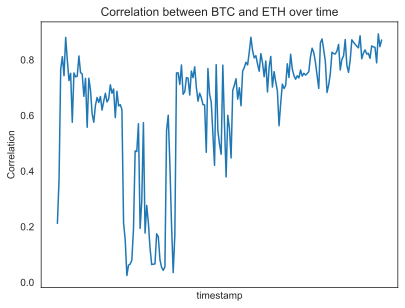

In [13]:
lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)
two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH over time");

In [14]:
ltc = crypto_df[crypto_df["Asset_ID"]==9].set_index("timestamp") # litecoin
ltc = ltc.reindex(range(ltc.index[0],ltc.index[-1]+60,60),method='pad')  # filling the blanks 
ltc_mini_2021 = ltc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')] 

In [15]:
lret_ltc = log_return(ltc_mini_2021.Close)[1:]
lret_ltc.rename('lret_ltc', inplace=True)

lret_ltc_long = log_return(ltc.Close)[1:]
lret_ltc_long.rename('lret_ltc', inplace=True)

timestamp
1514764920   -0.001555
1514764980    0.005072
1514765040   -0.007662
1514765100   -0.002031
1514765160   -0.003099
                ...   
1632182160   -0.002359
1632182220   -0.003906
1632182280   -0.001038
1632182340    0.005811
1632182400   -0.001790
Name: lret_ltc, Length: 1956959, dtype: float64

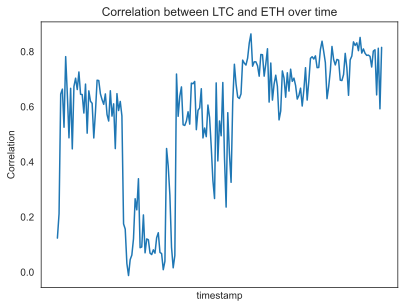

In [16]:

two_assets = pd.concat([lret_ltc_long, lret_eth_long], axis=1)



# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_ltc"].loc[:,"lret_eth"]

corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between LTC and ETH over time");

In [46]:
asset_details = pd.read_csv('asset_details.csv')
asset_details

Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin_Cash
1          0  4.304065      Binance_Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS_IO
4          7  2.079442  Ethereum_Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin

In [48]:
import time
from datetime import datetime

# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = crypto_df[crypto_df["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")


In [21]:
all_assets_2021['Time'] = all_assets_2021.index

In [22]:
# all_assets_2021['Time']  = pd.to_datetime(all_assets_2021['Time'] )

In [23]:
all_assets_2021.head()

Close  CloseBinance_Coin  CloseBitcoin  CloseEOS_IO   
timestamp                                                            
1609448460 -0.001018           0.000718     -0.002093    -0.001962  \
1609448520 -0.000409          -0.001340     -0.001976    -0.000725   
1609448580  0.000299           0.000044     -0.000299     0.000521   
1609448640  0.000110          -0.000967     -0.000214     0.000484   
1609448700 -0.000884          -0.001582     -0.001908    -0.001114   

            CloseEthereum_Classic  CloseEthereum  CloseLitecoin  CloseMonero   
timestamp                                                                      
1609448460              -0.000859      -0.001870      -0.000885    -0.000652  \
1609448520              -0.000920      -0.002011      -0.001015    -0.001528   
1609448580               0.001277       0.001208      -0.000582     0.000303   
1609448640               0.000230      -0.000584      -0.000242     0.000191   
1609448700              -0.001669      -0.002247      -0.002086    -0.000595   

            CloseTRON  CloseStellar  CloseCardano  CloseIOTA  CloseMaker   
timestamp                                                                  
1609448460  -0.000225     -0.000419     -0.000088  -0.000170    0.000504  \
1609448520  -0.000799     -0.000862     -0.000181  -0.002044    0.000178   
1609448580   0.000777     -0.000588     -0.000080   0.000341   -0.000595   
1609448640   0.000140     -0.000521      0.000076  -0.000170    0.000027   
1609448700  -0.000505     -0.001811     -0.000617  -0.000853   -0.000996   

            CloseDogecoin        Time  
timestamp                              
1609448460      -0.001083  1609448460  
1609448520      -0.000676  1609448520  
1609448580      -0.000215  1609448580  
1609448640       0.000054  1609448640  
1609448700       0.000386  1609448700

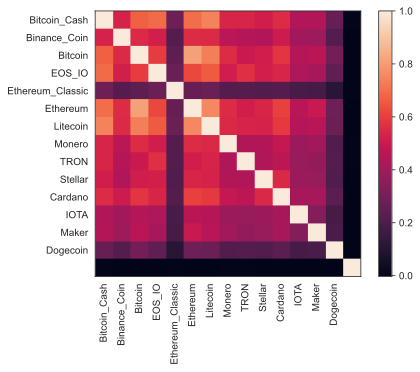

In [24]:
plt.imshow(all_assets_2021.corr());
plt.yticks(range(14), asset_details.Asset_Name.values);
plt.xticks(range(14), asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();

In [25]:
y, X = dmatrices('CloseBitcoin ~  Time + CloseEOS_IO + CloseEthereum', data=all_assets_2021, return_type='dataframe')

In [26]:
import statsmodels.tsa as tsa

In [27]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle = False)

In [64]:
y_train['time'] = y_train.index
y_train['time'] = y_train['time'] .apply(lambda x: datetime.fromtimestamp(x))
y_train = y_train.set_index("time")

In [69]:
y_test['time'] = y_test.index
y_test['time'] = y_test['time'] .apply(lambda x: datetime.fromtimestamp(x))
y_test = y_test.set_index("time")

In [68]:
mod = tsa.arima.model.ARIMA(y_train,  order = (2,0,2))
res = mod.fit()
print(res.summary())

/home/andrey/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/andrey/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/home/andrey/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           CloseBitcoin   No. Observations:               138240
Model:                 ARIMA(2, 0, 2)   Log Likelihood              700310.611
Date:                Tue, 23 May 2023   AIC                       -1400609.223
Time:                        06:37:25   BIC                       -1400550.202
Sample:                    01-01-2021   HQIC                      -1400591.568
                         - 04-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.999e-06   4.22e-06      1.183      0.237   -3.28e-06    1.33e-05
ar.L1          0.1086      0.045      2.420      0.016       0.021       0.196
ar.L2         -0.1447      0.025     -5.688      0.0

In [71]:
res.params

const     0.000005
ar.L1     0.108551
ar.L2    -0.144665
ma.L1    -0.050755
ma.L2     0.109686
sigma2    0.000002
dtype: float64

In [150]:
test_crypto_df = pd.read_csv('example_test.csv')

In [72]:
y_test

CloseBitcoin
time                             
2021-04-07 00:01:00     -0.000003
2021-04-07 00:02:00     -0.001224
2021-04-07 00:03:00      0.000644
2021-04-07 00:04:00      0.000099
2021-04-07 00:05:00     -0.000235
...                           ...
2021-04-30 23:56:00     -0.000085
2021-04-30 23:57:00     -0.000012
2021-04-30 23:58:00      0.001271
2021-04-30 23:59:00      0.000106
2021-05-01 00:00:00      0.001281

[34560 rows x 1 columns]

In [73]:
ypred = res.predict(start = '2021-04-07 00:01:00', end = '2021-05-01 00:00:00')

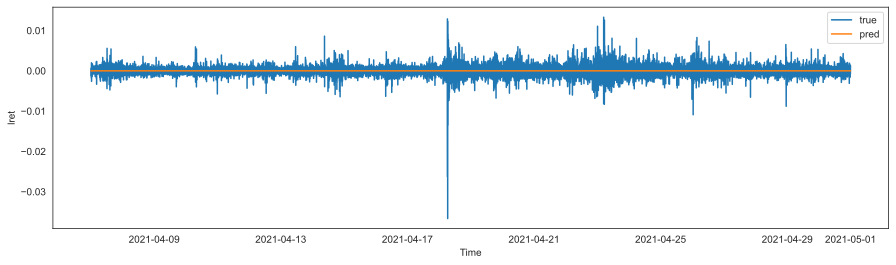

In [74]:
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))


plt.plot(y_test, label='true')
plt.plot(ypred, label='pred')

plt.legend()
plt.xlabel('Time')
plt.ylabel('lret')

# plt.tight_layout()
plt.show()